### Library Imports

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import nltk

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from wordcloud import WordCloud, STOPWORDS


from operator import itemgetter
import matplotlib as mpl
%matplotlib inline

C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


### Importing Dataset for Toronto Restaurants.
--load business.json data which contains features related to business
--We selected data for restautrant business in Toronto city 
--Grouping reviews of toronto restaurants into one and merging it with original dataset

In [3]:
#load business.json data
business_data = []
with open('business.json', encoding="utf8") as f:
    for line in f:
        business_data.append(json.loads(line))
business_df = pd.DataFrame.from_dict(business_data)
business_df.head()

Toronto_sample =business_df[business_df['city'].str.contains('Toronto')]

#Filtering out restaurants in Toronto
Toronto_restaurants=Toronto_sample[ (Toronto_sample.categories.str.contains('Restaurant', na=False))]

FileNotFoundError: [Errno 2] No such file or directory: 'business.json'

In [9]:
#load reviews.json data
# review_data = []
# with open('review.json', encoding="utf8") as f:
#     for line in f:
#         review_data.append(json.loads(line))
# review_df = pd.DataFrame.from_dict(review_data)
# review_df.head()
# review_df.to_pickle("Reviews.pkl")

In [10]:
#Reading Review.pkl file
review_df = pd.read_pickle("Reviews.pkl")

#Review of those businesses present in business dataframe
Toronto_rev = review_df[review_df.business_id.isin(Toronto_restaurants['business_id']) == True]

##grouping reviews for each restaurant into one
Reviews_Final=Toronto_rev.groupby('business_id')['text'].apply(' '.join).reset_index()

#Merging groped reviews into our original dataset
Toronto_Restaurant=Toronto_restaurants.merge(Reviews_Final, on='business_id',how='inner')

Toronto_Restaurant.to_pickle('Toronto_Restaurants.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'Reviews.pkl'

In [4]:
#Reading Toronto Pickle file
dataset=pd.read_pickle('Toronto_Restaurants.pkl')

In [5]:
#Checking for Null values
dataset.isnull().sum().sort_values(ascending=False)

hours           1900
attributes       350
text               0
categories         0
is_open            0
review_count       0
stars              0
longitude          0
latitude           0
postal_code        0
state              0
city               0
address            0
name               0
business_id        0
dtype: int64

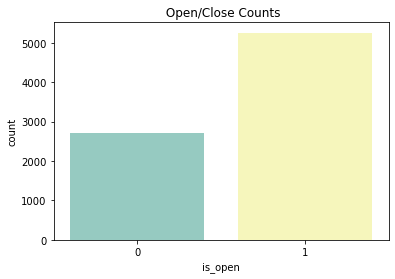

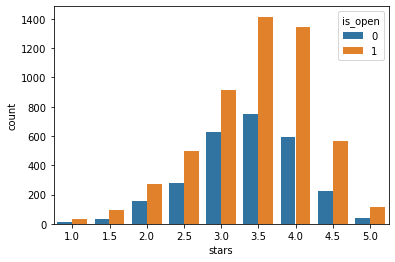

In [6]:
#Distribution count of open and closed restaurants
c = sns.countplot(x="is_open", data=dataset, palette="Set3").set_title(" Open/Close Counts")
plt.show()
plt.close()
#visualize the frequency of the ratings w.r.t to open and close restaurants
sns.countplot(x='stars' ,hue="is_open",data=dataset);

In [7]:
#looking at the data 
dataset.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,text
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,1,"{'WiFi': 'u'no'', 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",Pretty solid vegan spot. Had a rice bowl there...
1,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Uh..I'm so sad I didn't know about this place ...


# Feature Extraction

##### Extracting cuisine from  category column

In [8]:
## select out 17 cuisine types of restaurants and rename the category
dataset.is_copy=False
dataset['category']=pd.Series()
searchfor = ['American', 'American (Traditional)','American (New)']
dataset.loc[dataset.categories.str.contains('American'),'category'] = 'American'
dataset.loc[dataset.categories.str.contains('Mexican'), 'category'] = 'Mexican'
dataset.loc[dataset.categories.str.contains('Italian'), 'category'] = 'Italian'
dataset.loc[dataset.categories.str.contains('Japanese'), 'category'] = 'Japanese'
dataset.loc[dataset.categories.str.contains('Chinese'), 'category'] = 'Chinese'
dataset.loc[dataset.categories.str.contains('Thai'), 'category'] = 'Thai'
dataset.loc[dataset.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
dataset.loc[dataset.categories.str.contains('French'), 'category'] = 'French'
dataset.loc[dataset.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
dataset.loc[dataset.categories.str.contains('Greek'),'category'] = 'Greek'
dataset.loc[dataset.categories.str.contains('Indian'),'category'] = 'Indian'
dataset.loc[dataset.categories.str.contains('Korean'),'category'] = 'Korean'
dataset.loc[dataset.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
dataset.loc[dataset.categories.str.contains('African'),'category'] = 'African'
dataset.loc[dataset.categories.str.contains('Spanish'),'category'] = 'Spanish'
dataset.loc[dataset.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
dataset.loc[dataset.categories.str.contains('Breakfast & Brunch'),'category'] = 'Breakfast & Brunch'
#dataset.loc[dataset.categories.str.contains('Food'),'category'] = 'Food'
dataset.category[:20]

C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5191: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.

C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5192: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.



0                    NaN
1     Breakfast & Brunch
2     Breakfast & Brunch
3                Italian
4                Mexican
5                    NaN
6     Breakfast & Brunch
7                    NaN
8                    NaN
9                    NaN
10            Vietnamese
11                   NaN
12    Breakfast & Brunch
13               Mexican
14              Japanese
15               Italian
16                   NaN
17               Mexican
18               Chinese
19                   NaN
Name: category, dtype: object

In [9]:
## drop null values in category, delete original column categories and reset the index
dataset=dataset.dropna(axis=0, subset=['category'])
del dataset['categories']
dataset=dataset.reset_index(drop=True)
dataset.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,text,category
0,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': '{'garage': False, 'street...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Uh..I'm so sad I didn't know about this place ...,Breakfast & Brunch
1,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Alcohol': 'u'full_bar'', 'Caters': 'False', ...","{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",As a vegetarian I'm not loving the food offeri...,Breakfast & Brunch
2,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'Fals...",None,Great new addition to Toronto's dining scene.\...,Italian


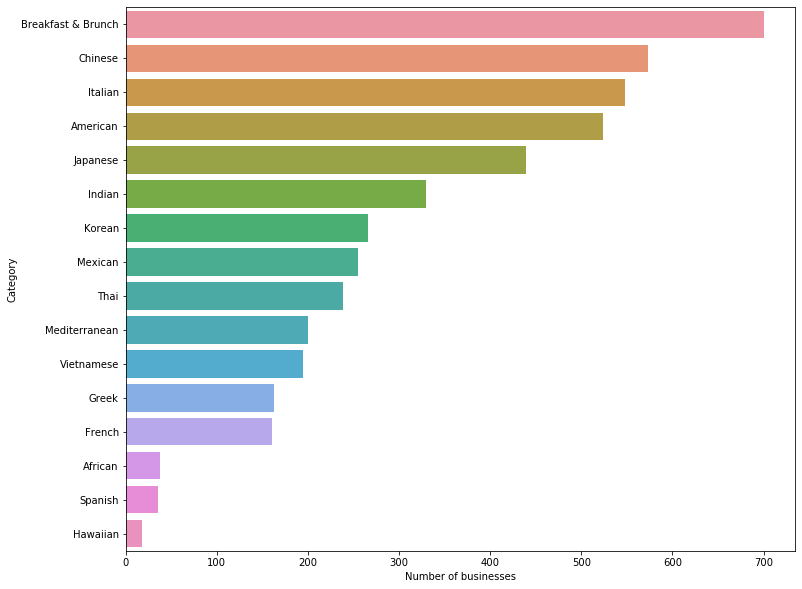

In [10]:
#Visualization plot for different cuisine extracted
business_cats=';'.join(dataset['category'])
cats=pd.DataFrame(business_cats.split(';'),columns=['category'])
cats_ser = cats.category.value_counts()


cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

plt.figure(figsize=(12,10))
f = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
f.set_ylabel('Category')
f.set_xlabel('Number of businesses');

##### Extracting restaurant specific features from  attributes column

In [11]:
dataset['attributes']
df_pol_ps = dataset['attributes'].apply(pd.Series)
dataset_final = pd.concat([dataset, df_pol_ps], axis = 1).drop('attributes', axis = 1)
dataset_final.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,text,category,BusinessParking,RestaurantsReservations,GoodForKids,RestaurantsAttire,Alcohol,OutdoorSeating,RestaurantsPriceRange2,NoiseLevel,RestaurantsDelivery,WiFi,RestaurantsTakeOut,HasTV,BikeParking,Ambience,RestaurantsGoodForGroups,Caters,Smoking,WheelchairAccessible,DogsAllowed,CoatCheck,RestaurantsTableService,HappyHour,Music,BestNights,GoodForMeal,ByAppointmentOnly,GoodForDancing,BusinessAcceptsCreditCards,DriveThru,DietaryRestrictions,AgesAllowed,RestaurantsCounterService,BusinessAcceptsBitcoin
0,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Uh..I'm so sad I didn't know about this place ...,Breakfast & Brunch,"{'garage': False, 'street': True, 'validated':...",True,False,u'casual',u'full_bar',False,2,u'average',False,u'free',False,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",As a vegetarian I'm not loving the food offeri...,Breakfast & Brunch,"{'garage': False, 'street': True, 'validated':...",True,False,'dressy',u'full_bar',True,3,NaN,False,u'free',True,False,True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,u'no',True,False,False,True,False,"{'dj': False, 'background_music': False, 'no_m...","{'monday': False, 'tuesday': False, 'friday': ...","{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,None,Great new addition to Toronto's dining scene.\...,Italian,"{'garage': False, 'street': True, 'validated':...",True,False,u'casual',u'full_bar',False,2,u'quiet',NaN,NaN,NaN,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,1614 Queen Street E,Toronto,ON,M4L 1G4,43.666181,-79.316468,3.5,43,1,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","After spending the day at Woodbine Beach, I wa...",Mexican,"{'garage': False, 'street': True, 'validated':...",False,True,u'casual',u'none',False,2,u'average',False,u'no',True,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,165 East Liberty Street,Toronto,ON,M6K 3K4,43.638442,-79.417237,2.0,40,1,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",I have eaten middle eastern food all over Toro...,Breakfast & Brunch,"{'garage': False, 'street': False, 'validated'...",True,True,'casual',u'none',True,2,u'average',True,u'free',True,True,True,"{'touristy': False, 'hipster': False, 'romanti...",True,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
dataset_final.isnull().sum().sort_values(ascending=False)
#dataset_final=dataset_final.drop(columns=['RestaurantsCounterService','hours','RestaurantsAttire','Ambience','BusinessParking', 'BusinessAcceptsBitcoin','HairSpecializesIn','AcceptsInsurance','AgesAllowed','DietaryRestrictions','ByAppointmentOnly','BusinessAcceptsCreditCards','DriveThru','BestNights','Smoking','CoatCheck','Music','HappyHour','GoodForDancing','DogsAllowed','WheelchairAccessible','RestaurantsTableService','GoodForMeal','Caters','BikeParking','WiFi','NoiseLevel','Alcohol','HasTV'])

BusinessAcceptsBitcoin        4681
AgesAllowed                   4681
RestaurantsCounterService     4681
DietaryRestrictions           4677
ByAppointmentOnly             4659
DriveThru                     4587
BestNights                    4526
BusinessAcceptsCreditCards    4516
Smoking                       4499
CoatCheck                     4496
Music                         4447
GoodForDancing                4437
HappyHour                     4436
DogsAllowed                   4270
WheelchairAccessible          4019
RestaurantsTableService       3086
GoodForMeal                   2255
Caters                        1963
BikeParking                   1657
WiFi                          1377
NoiseLevel                    1202
Alcohol                       1097
hours                         1069
HasTV                         1025
Ambience                      1006
BusinessParking                929
OutdoorSeating                 809
RestaurantsAttire              777
RestaurantsDelivery 

In [13]:
#Getting the count of the highest percentage of missing values
Count = dataset_final.isnull().sum().sort_values(ascending=False)
#Calculation for percentage
percent = (dataset_final.isnull().sum()/dataset_final.isnull().count()).sort_values(ascending=False)
#Creating a dataframe and appending columns and the percentage
missing_data = pd.concat([Count, percent], axis=1, keys=['Total', 'Percent'])
#Printing top 25
missing_data.head(30)

,Total,Percent
BusinessAcceptsBitcoin,4681,0.999786
AgesAllowed,4681,0.999786
RestaurantsCounterService,4681,0.999786
DietaryRestrictions,4677,0.998932
ByAppointmentOnly,4659,0.995088
DriveThru,4587,0.979710
BestNights,4526,0.966681
BusinessAcceptsCreditCards,4516,0.964545
Smoking,4499,0.960914
CoatCheck,4496,0.960273


In [14]:
#We see from the description of the data features that have most NAN values
missing_features = percent[percent > 0.50].index
dataset_final.drop(missing_features, axis=1, inplace=True)
print(dataset_final.shape)

(4682, 31)


In [15]:
dataset_final.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,text,category,BusinessParking,RestaurantsReservations,GoodForKids,RestaurantsAttire,Alcohol,OutdoorSeating,RestaurantsPriceRange2,NoiseLevel,RestaurantsDelivery,WiFi,RestaurantsTakeOut,HasTV,BikeParking,Ambience,RestaurantsGoodForGroups,Caters,GoodForMeal
0,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Uh..I'm so sad I didn't know about this place ...,Breakfast & Brunch,"{'garage': False, 'street': True, 'validated':...",True,False,u'casual',u'full_bar',False,2,u'average',False,u'free',False,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,NaN
1,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",As a vegetarian I'm not loving the food offeri...,Breakfast & Brunch,"{'garage': False, 'street': True, 'validated':...",True,False,'dressy',u'full_bar',True,3,NaN,False,u'free',True,False,True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,"{'dessert': False, 'latenight': False, 'lunch'..."
2,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,None,Great new addition to Toronto's dining scene.\...,Italian,"{'garage': False, 'street': True, 'validated':...",True,False,u'casual',u'full_bar',False,2,u'quiet',NaN,NaN,NaN,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,NaN,"{'dessert': False, 'latenight': False, 'lunch'..."
3,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,1614 Queen Street E,Toronto,ON,M4L 1G4,43.666181,-79.316468,3.5,43,1,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","After spending the day at Woodbine Beach, I wa...",Mexican,"{'garage': False, 'street': True, 'validated':...",False,True,u'casual',u'none',False,2,u'average',False,u'no',True,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,False,NaN
4,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,165 East Liberty Street,Toronto,ON,M6K 3K4,43.638442,-79.417237,2.0,40,1,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",I have eaten middle eastern food all over Toro...,Breakfast & Brunch,"{'garage': False, 'street': False, 'validated'...",True,True,'casual',u'none',True,2,u'average',True,u'free',True,True,True,"{'touristy': False, 'hipster': False, 'romanti...",True,True,"{'dessert': False, 'latenight': False, 'lunch'..."


In [16]:
dataset_final.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,text,category,BusinessParking,RestaurantsReservations,GoodForKids,RestaurantsAttire,Alcohol,OutdoorSeating,RestaurantsPriceRange2,NoiseLevel,RestaurantsDelivery,WiFi,RestaurantsTakeOut,HasTV,BikeParking,Ambience,RestaurantsGoodForGroups,Caters,GoodForMeal
0,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Uh..I'm so sad I didn't know about this place ...,Breakfast & Brunch,"{'garage': False, 'street': True, 'validated':...",True,False,u'casual',u'full_bar',False,2,u'average',False,u'free',False,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,NaN
1,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",As a vegetarian I'm not loving the food offeri...,Breakfast & Brunch,"{'garage': False, 'street': True, 'validated':...",True,False,'dressy',u'full_bar',True,3,NaN,False,u'free',True,False,True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,"{'dessert': False, 'latenight': False, 'lunch'..."
2,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,None,Great new addition to Toronto's dining scene.\...,Italian,"{'garage': False, 'street': True, 'validated':...",True,False,u'casual',u'full_bar',False,2,u'quiet',NaN,NaN,NaN,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,NaN,"{'dessert': False, 'latenight': False, 'lunch'..."
3,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,1614 Queen Street E,Toronto,ON,M4L 1G4,43.666181,-79.316468,3.5,43,1,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","After spending the day at Woodbine Beach, I wa...",Mexican,"{'garage': False, 'street': True, 'validated':...",False,True,u'casual',u'none',False,2,u'average',False,u'no',True,False,True,"{'romantic': False, 'intimate': False, 'classy...",True,False,NaN
4,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,165 East Liberty Street,Toronto,ON,M6K 3K4,43.638442,-79.417237,2.0,40,1,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",I have eaten middle eastern food all over Toro...,Breakfast & Brunch,"{'garage': False, 'street': False, 'validated'...",True,True,'casual',u'none',True,2,u'average',True,u'free',True,True,True,"{'touristy': False, 'hipster': False, 'romanti...",True,True,"{'dessert': False, 'latenight': False, 'lunch'..."


# Encoding Categorical features

In [17]:
dataset_final.isnull().sum().sort_values(ascending=False)

GoodForMeal                 2255
Caters                      1963
BikeParking                 1657
WiFi                        1377
NoiseLevel                  1202
Alcohol                     1097
hours                       1069
HasTV                       1025
Ambience                    1006
BusinessParking              929
OutdoorSeating               809
RestaurantsAttire            777
RestaurantsDelivery          769
RestaurantsReservations      670
GoodForKids                  655
RestaurantsGoodForGroups     576
RestaurantsPriceRange2       561
RestaurantsTakeOut           504
latitude                       0
name                           0
address                        0
city                           0
state                          0
postal_code                    0
stars                          0
longitude                      0
review_count                   0
is_open                        0
text                           0
category                       0
business_i

In [18]:
for column in dataset_final[['hours','Ambience','HasTV','NoiseLevel','RestaurantsAttire','Alcohol','BusinessParking','Caters','BikeParking','WiFi']]:
    dataset_final[column].fillna(dataset_final[column].value_counts().index[0], inplace=True)
#     mode = dataset_final[column].mode()
#     dataset_final[column] = dataset_final[column].fillna(mode)

In [19]:
#Feature Extraction
import ast
dataset_final["Ambience"] =  dataset_final["Ambience"].map(lambda d : ast.literal_eval(d))
dataset_final = dataset_final.join(pd.DataFrame(dataset_final["Ambience"].to_dict()).T)
del dataset_final['Ambience']

#Business Parking
dataset_final["BusinessParking"] =  dataset_final["BusinessParking"].map(lambda d : ast.literal_eval(d))
dataset_final = dataset_final.join(pd.DataFrame(dataset_final["BusinessParking"].to_dict()).T)
del dataset_final['BusinessParking']

# #GoodforMeal
# dataset_final["GoodForMeal"] =  dataset_final["GoodForMeal"].map(lambda d : ast.literal_eval(d))
# dataset_final = dataset_final.join(pd.DataFrame(dataset_final["GoodForMeal"].to_dict()).T)
del dataset_final['GoodForMeal']


In [20]:
#Encoding True and False to 0 and 1 , converting them to numeric and filling the null with max count
dataset_final.info()
columns=['RestaurantsTakeOut','RestaurantsReservations','GoodForKids','OutdoorSeating','RestaurantsDelivery','romantic',                    
'RestaurantsGoodForGroups','intimate' , 'BikeParking',"Caters",'HasTV','RestaurantsPriceRange2',                        
'classy',                      
'hipster',                     
'divey',                       
'touristy',                    
'trendy',                      
'upscale',                     
'casual',                      
'garage',                      
'street',                     
'validated',                   
'lot',                         
'valet']
for col in columns:
    dataset_final[col]=dataset_final[col].replace(['True'], 1)
    dataset_final[col]=dataset_final[col].replace(['False'], 0)
    dataset_final[col]=pd.to_numeric(dataset_final[col], errors='coerce')
    dataset_final[col].fillna(dataset_final[col].value_counts().index[0], inplace=True)
    
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4682 entries, 0 to 4681
Data columns (total 42 columns):
business_id                 4682 non-null object
name                        4682 non-null object
address                     4682 non-null object
city                        4682 non-null object
state                       4682 non-null object
postal_code                 4682 non-null object
latitude                    4682 non-null float64
longitude                   4682 non-null float64
stars                       4682 non-null float64
review_count                4682 non-null int64
is_open                     4682 non-null int64
hours                       3613 non-null object
text                        4682 non-null object
category                    4682 non-null object
RestaurantsReservations     4012 non-null object
GoodForKids                 4027 non-null object
RestaurantsAttire           4682 non-null object
Alcohol                     4682 non-null object
OutdoorSea

In [21]:
dataset_final.isnull().sum().sort_values(ascending=False)

hours                       1069
valet                          0
is_open                        0
OutdoorSeating                 0
Alcohol                        0
RestaurantsAttire              0
GoodForKids                    0
RestaurantsReservations        0
category                       0
text                           0
review_count                   0
lot                            0
stars                          0
longitude                      0
latitude                       0
postal_code                    0
state                          0
city                           0
address                        0
name                           0
RestaurantsPriceRange2         0
NoiseLevel                     0
RestaurantsDelivery            0
WiFi                           0
validated                      0
street                         0
garage                         0
casual                         0
upscale                        0
trendy                         0
touristy  

In [22]:
#Dropping Divery as it has just one value which is zero
print(dataset_final['divey'].value_counts())
del dataset_final['divey']

0.0    4682
Name: divey, dtype: int64


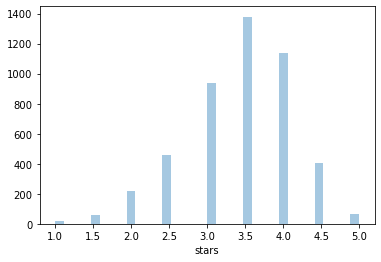

In [23]:
#a=dataset_final['category'].value_counts()
#sns.boxplot(dataset_final.category);
sns.distplot(dataset_final.stars, kde=False)

In [24]:
dataset_final.isnull().sum().sort_values(ascending=False)

hours                       1069
valet                          0
RestaurantsPriceRange2         0
Alcohol                        0
RestaurantsAttire              0
GoodForKids                    0
RestaurantsReservations        0
category                       0
text                           0
is_open                        0
review_count                   0
stars                          0
longitude                      0
latitude                       0
postal_code                    0
state                          0
city                           0
address                        0
name                           0
OutdoorSeating                 0
NoiseLevel                     0
lot                            0
RestaurantsDelivery            0
validated                      0
street                         0
garage                         0
casual                         0
upscale                        0
trendy                         0
touristy                       0
hipster   

In [25]:
encoded = dataset_final[['category','WiFi','NoiseLevel','RestaurantsAttire','Alcohol']]
encoded = pd.get_dummies(encoded)
dataset_final = dataset_final.merge(encoded, left_index = True, right_index = True)
dataset_final.drop(dataset_final[['category','WiFi','NoiseLevel','RestaurantsAttire','Alcohol','NoiseLevel','RestaurantsAttire']], axis = 1,inplace=True)
# # pd.DataFrame(encoded)
# # encoded.info()
dataset_final.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,text,RestaurantsReservations,GoodForKids,OutdoorSeating,RestaurantsPriceRange2,RestaurantsDelivery,RestaurantsTakeOut,HasTV,BikeParking,RestaurantsGoodForGroups,Caters,romantic,intimate,...,WiFi_u'no',WiFi_u'paid',NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_None,NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none'
0,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",Uh..I'm so sad I didn't know about this place ...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",As a vegetarian I'm not loving the food offeri...,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,NaN,Great new addition to Toronto's dining scene.\...,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,1614 Queen Street E,Toronto,ON,M4L 1G4,43.666181,-79.316468,3.5,43,1,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","After spending the day at Woodbine Beach, I wa...",0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,165 East Liberty Street,Toronto,ON,M6K 3K4,43.638442,-79.417237,2.0,40,1,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",I have eaten middle eastern food all over Toro...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
dataset_final.isnull().sum().sort_values(ascending=False)

hours                          1069
Alcohol_u'none'                   0
upscale                           0
Caters                            0
romantic                          0
intimate                          0
classy                            0
hipster                           0
touristy                          0
trendy                            0
casual                            0
BikeParking                       0
garage                            0
street                            0
validated                         0
lot                               0
valet                             0
category_African                  0
category_American                 0
category_Breakfast & Brunch       0
RestaurantsGoodForGroups          0
HasTV                             0
Alcohol_u'full_bar'               0
stars                             0
name                              0
address                           0
city                              0
state                       

# The top business names in our dataset can be visualized with a word cloud.

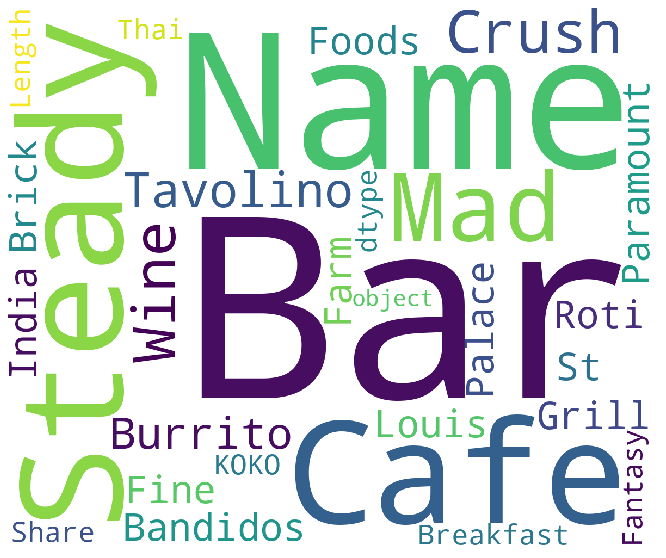

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                          width=1200,
                      stopwords = STOPWORDS,
                          height=1000
                         ).generate(str(dataset_final['name']))


plt.imshow(wordcloud)
plt.axis('off');

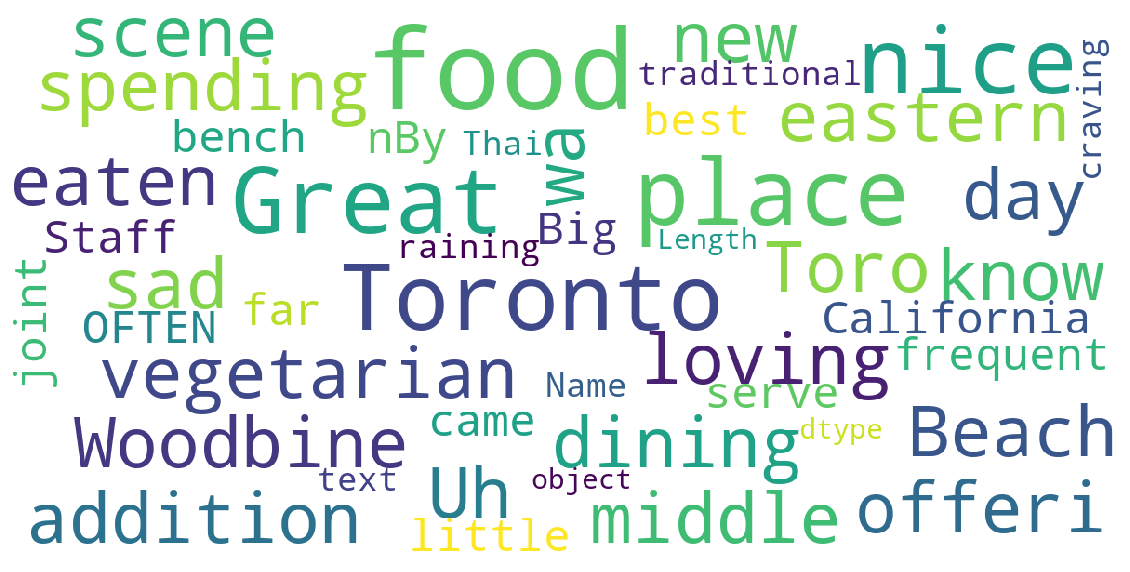

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(dataset_final["text"])

In [29]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 30 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

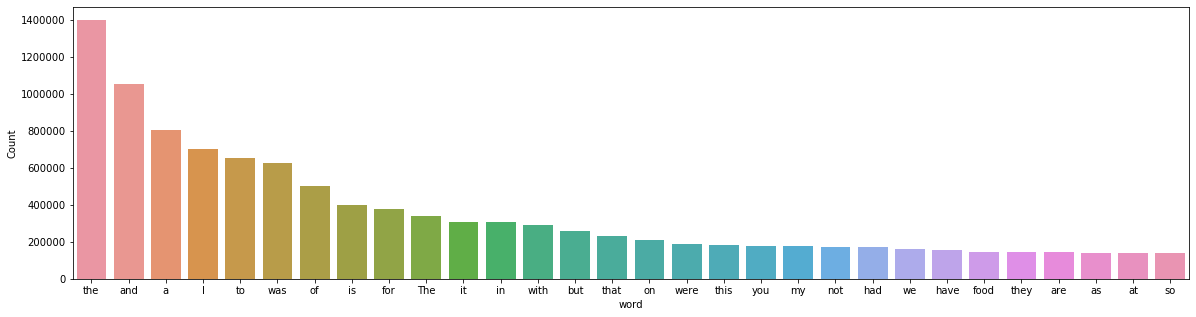

In [30]:
freq_words(dataset_final['text'])

In [31]:
# remove unwanted characters, numbers and symbols
dataset_final['text'] = dataset_final['text'].str.replace("[^a-zA-Z#]", " ")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new


In [32]:
# remove short words (length < 3)
dataset_final['text'] = dataset_final['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in dataset_final['text']]

# make entire text lowercase
dataset_final['text_lower'] = [r.lower() for r in reviews]


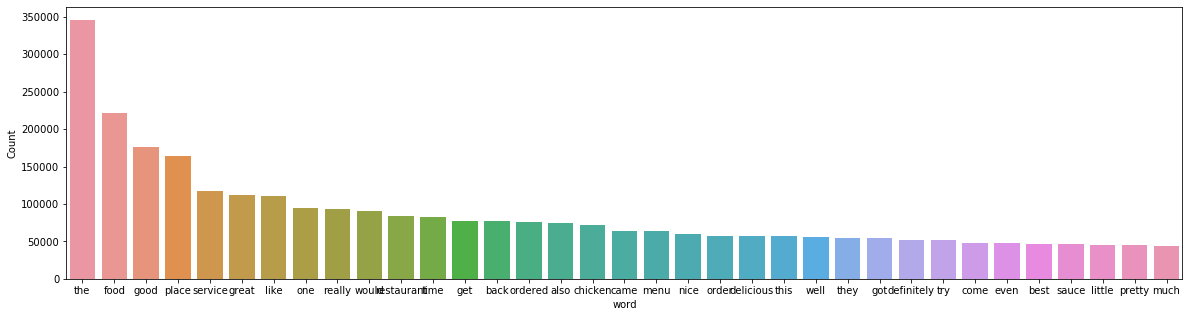

In [34]:
freq_words(dataset_final['text_lower'], 35)

Polarity: Polarity score is a float within the range [-1.0, 1.0], also known as orientation polarity is the emotion expressed in the sentence. It can be positive, negative or neutral.
Subjectivity: It measures subjectivity of sentence or to what extent it represents someones personal feelings, views, or beliefs compared to objective truth or facts. subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [35]:
from textblob import TextBlob

def sentiment(x):
    #Lets find review sentiment for each review similarly
    polarity_list,subjectivity_list=[],[]
    for i in range(len(x)):
        blob = TextBlob(x[i])
        polarity_list.append(blob.sentiment.polarity)
        subjectivity_list.append(blob.sentiment.subjectivity)
    return polarity_list,subjectivity_list

In [36]:
#polarity_list,subjectivity_list = dataset_final['text'].apply(sentiment)
polarity_list,subjectivity_list = sentiment(dataset_final['text_lower'])

In [37]:
dataset_final['review_polarity']=pd.DataFrame(polarity_list)
dataset_final['review_subjectivity']=pd.DataFrame(subjectivity_list)

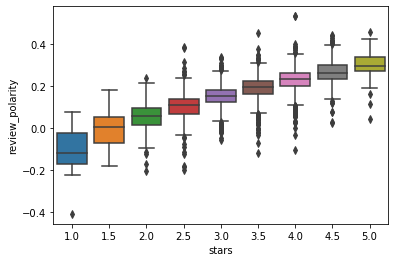

In [38]:
sns.boxplot(x = 'stars', y = 'review_polarity', data = dataset_final);

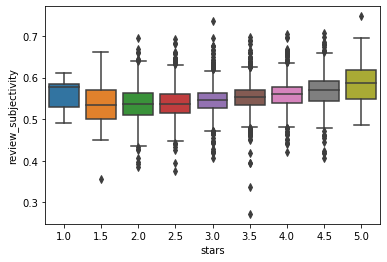

In [39]:
sns.boxplot(x = 'stars', y = 'review_subjectivity', data = dataset_final);

In [40]:
def keyword_subjectivity(keyword1, keyword2):
    sns.distplot(dataset_final[dataset_final['text'].str.contains(keyword1)]['review_subjectivity']) # keyword1
    sns.distplot(dataset_final[dataset_final['text'].str.contains(keyword2)]['review_subjectivity']) # keyword2
    plt.legend([keyword1, keyword2])
    plt.xlim([-0.5,1]);

In [41]:
def keyword_polarity(keyword1, keyword2):
    sns.distplot(dataset_final[dataset_final['text'].str.contains(keyword1)]['review_polarity']) # keyword1
    sns.distplot(dataset_final[dataset_final['text'].str.contains(keyword2)]['review_polarity']) # keyword2
    plt.legend([keyword1, keyword2])
    plt.xlim([-0.5,1]);

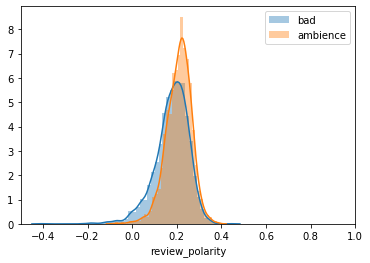

In [42]:
keyword_polarity('bad', 'ambience')

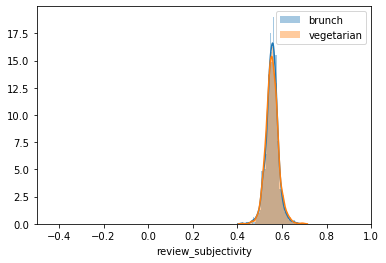

In [43]:
keyword_subjectivity('brunch', 'vegetarian')

In [44]:
dataset_final.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,text,RestaurantsReservations,GoodForKids,OutdoorSeating,RestaurantsPriceRange2,RestaurantsDelivery,RestaurantsTakeOut,HasTV,BikeParking,RestaurantsGoodForGroups,Caters,romantic,intimate,...,NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_None,NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',text_lower,review_polarity,review_subjectivity
0,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",sad didn know about this place sooner went her...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,sad know place sooner went brunch loved tons v...,0.210176,0.535315
1,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",vegetarian not loving the food offerings Every...,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,vegetarian loving food offerings everything wi...,0.266466,0.580881
2,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,NaN,Great new addition Toronto dining scene Simple...,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,great new addition toronto dining scene simple...,0.277282,0.564047
3,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,1614 Queen Street E,Toronto,ON,M4L 1G4,43.666181,-79.316468,3.5,43,1,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",After spending the day Woodbine Beach was look...,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,after spending day woodbine beach looking good...,0.140975,0.551741
4,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,165 East Liberty Street,Toronto,ON,M6K 3K4,43.638442,-79.417237,2.0,40,1,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",have eaten middle eastern food all over Toront...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,eaten middle eastern food toronto came lunch o...,0.076166,0.527437


In [45]:
dataset_final.drop(["RestaurantsAttire_u'casual'","RestaurantsAttire_u'dressy'","RestaurantsAttire_u'formal'","NoiseLevel_u'very_loud'","NoiseLevel_u'quiet'","NoiseLevel_u'loud'","NoiseLevel_u'average'","Alcohol_u'none'","Alcohol_u'full_bar'","Alcohol_u'beer_and_wine'","Alcohol_None","RestaurantsAttire_u'formal'","RestaurantsAttire_u'dressy'","RestaurantsAttire_u'casual'","WiFi_u'free'","WiFi_u'no'","WiFi_u'paid'"],axis=1,inplace=True)

In [46]:
dataset_final.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'hours',
       'text', 'RestaurantsReservations', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsPriceRange2', 'RestaurantsDelivery', 'RestaurantsTakeOut',
       'HasTV', 'BikeParking', 'RestaurantsGoodForGroups', 'Caters',
       'romantic', 'intimate', 'classy', 'hipster', 'touristy', 'trendy',
       'upscale', 'casual', 'garage', 'street', 'validated', 'lot', 'valet',
       'category_African', 'category_American', 'category_Breakfast & Brunch',
       'category_Chinese', 'category_French', 'category_Greek',
       'category_Hawaiian', 'category_Indian', 'category_Italian',
       'category_Japanese', 'category_Korean', 'category_Mediterranean',
       'category_Mexican', 'category_Spanish', 'category_Thai',
       'category_Vietnamese', 'WiFi_'free'', 'WiFi_'no'', 'WiFi_'paid'',
       'WiFi_None', 'NoiseLevel_'average'', 'NoiseLevel_'

In [47]:
dataset_final.drop(['WiFi_None',"NoiseLevel_'very_loud'", "NoiseLevel_None","RestaurantsAttire_'formal'",'RestaurantsAttire_None'],axis=1,inplace=True)


In [48]:
#Removing these columns to match Brampton.pkl features for testing on another city.
dataset_final.drop(['category_Hawaiian','category_Korean','hours','postal_code','business_id','name','address','city','text','text_lower','state'],axis=1,inplace=True)

In [49]:
dataset_final.shape

(4682, 55)

In [50]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#X=dataset_final.drop(['is_open'], axis=1)
X=dataset_final.drop(['is_open'], axis = 1)
y=dataset_final['is_open']
#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True)


Using TensorFlow backend.
C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\google\protobuf\descriptor.py:47: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



In [51]:
dataset_final.corr()

,latitude,longitude,stars,review_count,is_open,RestaurantsReservations,GoodForKids,OutdoorSeating,RestaurantsPriceRange2,RestaurantsDelivery,RestaurantsTakeOut,HasTV,BikeParking,RestaurantsGoodForGroups,Caters,romantic,intimate,classy,hipster,touristy,trendy,upscale,casual,garage,street,...,category_Breakfast & Brunch,category_Chinese,category_French,category_Greek,category_Indian,category_Italian,category_Japanese,category_Mediterranean,category_Mexican,category_Spanish,category_Thai,category_Vietnamese,WiFi_'free',WiFi_'no',WiFi_'paid',NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',RestaurantsAttire_'casual',RestaurantsAttire_'dressy',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',review_polarity,review_subjectivity
latitude,1.000000,0.380707,-0.077736,-0.124044,0.025309,0.038848,0.125534,-0.170304,-0.067191,-0.011658,0.087858,0.071443,-0.126810,0.024627,0.057048,-0.043220,-0.052295,-0.048321,-0.074200,-0.031532,-0.079522,-0.041127,-0.015991,-0.039221,-0.250183,...,-0.127948,0.313175,-0.060314,-0.008453,0.046905,-0.102587,-0.000987,0.010491,-0.050189,-0.022292,-0.037125,0.007192,0.006226,0.049759,0.023024,0.031501,0.015156,0.035199,0.096005,-0.029519,0.053591,0.012431,0.089606,-0.151405,-0.127897
longitude,0.380707,1.000000,-0.051562,0.003623,-0.040744,0.027703,0.024183,-0.029834,-0.036493,-0.018892,0.024066,0.003027,-0.009477,-0.009329,-0.004741,-0.018188,-0.002039,-0.012399,-0.044604,-0.003685,-0.008506,-0.011002,0.007426,0.004459,-0.082254,...,-0.026655,0.204768,-0.000818,0.049018,0.046774,-0.076065,-0.012638,-0.043230,-0.026678,-0.020284,-0.010174,-0.055846,0.015741,0.004213,0.028230,-0.001543,0.000992,0.012499,0.012772,-0.004797,0.009799,-0.001410,0.033275,-0.068798,-0.069899
stars,-0.077736,-0.051562,1.000000,0.140660,0.062446,0.009390,0.001044,0.007439,0.035495,-0.074502,-0.064155,-0.051874,-0.003661,-0.020240,-0.012773,0.045000,0.067604,0.046268,0.044150,-0.023111,0.054510,0.036405,0.011520,0.002397,0.056310,...,0.059969,-0.086877,0.082613,-0.006415,0.011177,-0.017182,0.034721,0.025104,-0.047909,0.037080,-0.071807,0.030848,-0.008270,0.039852,0.003062,0.061100,-0.023178,0.006694,0.040519,0.013946,0.008631,0.012938,0.041984,0.721662,0.233615
review_count,-0.124044,0.003623,0.140660,1.000000,0.204743,0.017877,-0.132212,0.118231,0.114781,-0.031662,-0.106871,-0.002404,0.005461,0.017917,-0.265222,0.015292,-0.002775,0.062279,0.115018,0.015611,0.208735,0.096125,0.093709,0.096232,0.133612,...,0.038064,-0.056454,0.000302,-0.037740,-0.048387,-0.022539,0.080042,-0.045296,0.015322,0.020176,0.018409,-0.001987,0.037100,0.006785,-0.009981,0.016312,0.019702,-0.028972,-0.035219,0.041144,0.030995,0.053731,-0.024585,0.133493,0.016259
is_open,0.025309,-0.040744,0.062446,0.204743,1.000000,-0.098472,0.048608,-0.050275,-0.062330,0.032054,0.048210,0.032390,-0.094061,-0.019896,-0.072971,-0.016646,-0.028124,-0.012000,0.034610,0.005214,0.005361,0.033167,0.068800,0.042012,-0.004578,...,0.034402,0.022338,-0.053519,0.016707,-0.006727,-0.024261,-0.003316,-0.008840,0.014789,0.012562,-0.015272,0.006418,0.085466,0.099029,0.006415,0.033948,0.028057,-0.004236,0.087409,0.015234,0.036544,0.020357,0.063034,0.000310,0.052595
RestaurantsReservations,0.038848,0.027703,0.009390,0.017877,-0.098472,1.000000,-0.120789,0.095600,0.406987,-0.006002,-0.119072,0.022659,0.033045,0.321486,0.072868,0.088363,0.097357,0.103949,-0.060883,0.013480,0.108408,0.064488,-0.001275,0.036321,0.056663,...,-0.112825,0.007061,0.068208,-0.045077,-0.006221,0.060282,0.071909,-0.045161,-0.126106,0.022569,0.067101,-0.055057,-0.017767,-0.091934,-0.039602,-0.034915,0.000389,-0.041623,-0.120411,0.056235,0.019574,0.071714,-0.172218,0.119821,0.061175
GoodForKids,0.125534,0.024183,0.001044,-0.132212,0.048608,-0.120789,1.000000,-0.148177,-0.345271,0.176258,0.353863,0.045056,0.029577,0.055391,0.133281,-0.158301,-0.147033,-0.170435,-0.100755,0.006640,-0.218278,-0.158820,0.219956,-0.066992,-0.065808,...,0.030035,0.103783,-0.174493,0.053004,0.054860,-0.083781,0.014213,0.007652,0.

In [52]:
dataset_final.shape

(4682, 55)

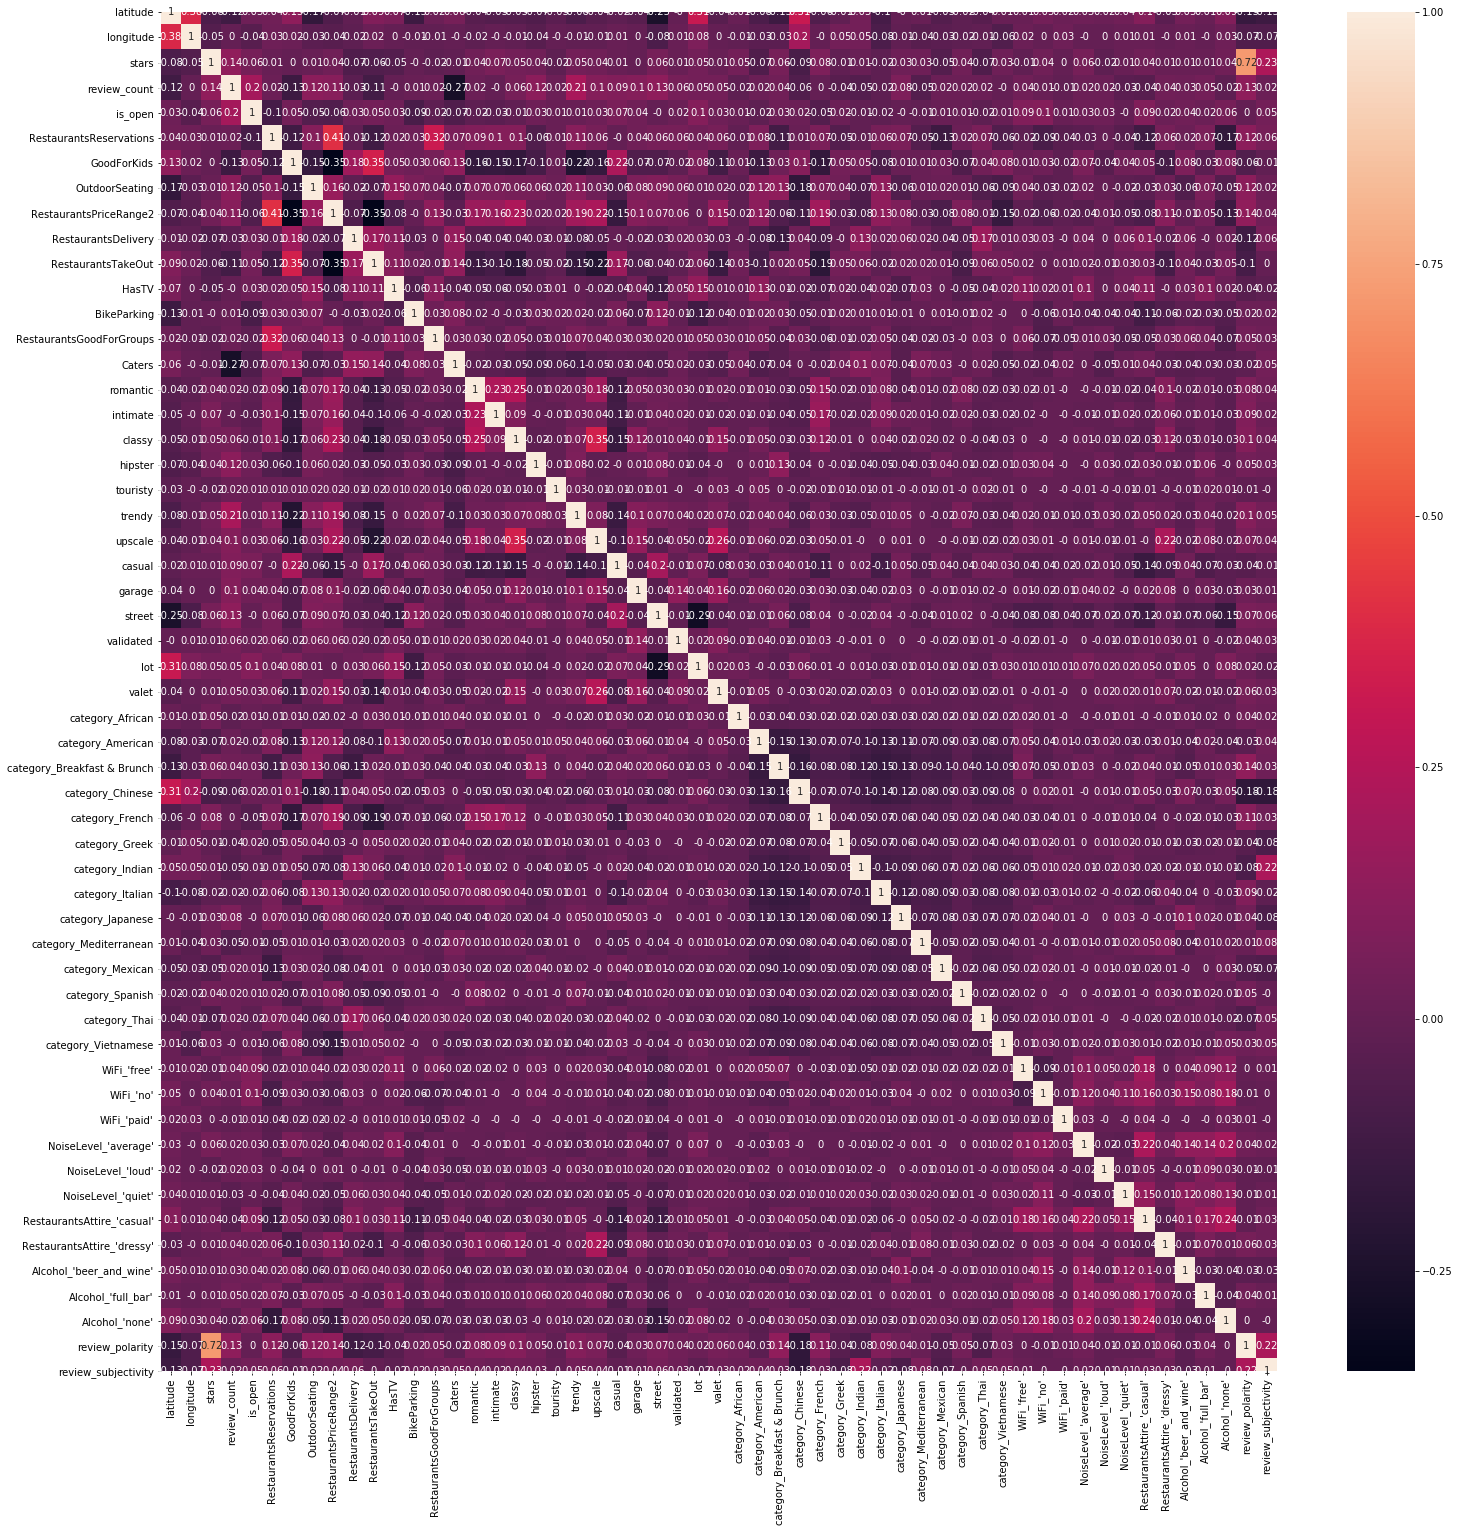

In [53]:
#dataset_final.corr()
fig, ax = plt.subplots(figsize=(25,25))
correlation_matrix = dataset_final.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [54]:
threshold=0.1
correlation = dataset_final.corr()
ser_corr = correlation.abs().nlargest(len(dataset_final), 'is_open')['is_open']

cols_abv_corr_limit = list(ser_corr[ser_corr.values > threshold].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= threshold].index)
cols_abv_corr_limit

['is_open', 'review_count', 'lot']

In [55]:
#Split data into a training and test set with SMOTE option. The dataset is imbalanced: only about 20% of resteraunts fail inspections. Synthetic 		resampling (SMOTE) can be used to create a more balanced training set. But the danger is that the synthetic samples are too 'synthetic' and so I 		overfit the training data.  
def split_data_train_test (X,y,test_size,Use_SMOTE=True,k=4,alpha=0.7):
    #Splitting the dataset 
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,shuffle=True)
    
    #scale the training data 
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    # Use SMOTE to oversample minority class in training data. To balance the cost of training on synthetic data with the benefit of more familiarity with the minority class, I apply a discounting factor of 0.8 to the resampling ratio that would fully equalize my two classes.   
    if Use_SMOTE == True:
        minority_count = y_train.sum()
        majority_count = len(y_train) - minority_count
        # We do not want LESS minority samples than the sample would produce. 
        if int(alpha * (majority_count//minority_count)) <= 1:
            res_ratio = 1
        else: 
            res_ratio = int(alpha * (majority_count//minority_count))
        X_train_SMOTE, y_train_SMOTE = SMOTE( ratio={0:majority_count, 1:int(res_ratio * minority_count)},k_neighbors=k,random_state=42).fit_sample(X_train_sc, y_train)
        X_train_SMOTE = pd.DataFrame(X_train_SMOTE,columns=X.columns)
        return X_train_SMOTE, X_test_sc ,y_train_SMOTE, y_test
    elif Use_SMOTE == False:
        return X_train_sc, X_test_sc, y_train, y_test

In [56]:
X_train, X_test, y_train, y_test=split_data_train_test(X,y,0.2,Use_SMOTE=True,k=4,alpha=0.7)

C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\deprecation.py:53: DeprecationWarning:

'ratio' is deprecated from 0.4 and will be removed in 0.6 for the estimator <class 'imblearn.over_sampling._smote.SMOTE'>. Use 'sampling_strategy' instead.



LR: 0.690941 (0.023322)
KNN: 0.639685 (0.021834)
CART: 0.617477 (0.031313)
NB: 0.554468 (0.015709)
SVM: 0.684323 (0.017159)


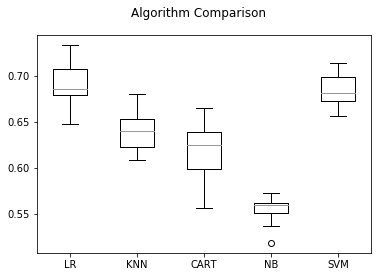

In [57]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
import warnings; warnings.simplefilter('ignore')
seed = 7
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#The example also provides a box and whisker plot showing the spread of the accuracy scores across each cross validation fold for each algorithm.

In [59]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('RF'   , RandomForestClassifier()))
    
    return basedModels

In [60]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    SEED=7
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [61]:
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [62]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.685713 (0.017897)
KNN: 0.621626 (0.026958)
CART: 0.623503 (0.019604)
NB: 0.552715 (0.042469)
SVM: 0.686525 (0.014061)
RF: 0.677444 (0.024542)


Grid search is designed with the notion that the loss function is affected by multiple hyper-parameter choices, hence we need to iterate through all the hyper parameter at some fix interval to assess all hyperparameters

However in most instances, the loss is often heavily reliant on only one or two hyper parameter and instead random search when used by a train personal provides the most information per compute.

In [63]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 20
        kfold = StratifiedKFold(n_splits=cv, random_state=7)
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=kfold,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred
    
        

In [64]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 20
        kfold = StratifiedKFold(n_splits=cv, random_state=7)
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=kfold,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred
    


In [65]:
# model
model = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
#
C = [1,3,4]
#uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
LR_RandSearch = RandomSearch(X_train,y_train,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test)

Best: 0.685981 using {'penalty': 'l1', 'C': 1}


In [71]:
def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" #first cast decimal as str
    #     print(prc) #str format output is {:.3f}
        return float(prc.format(f_val))

In [72]:
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_LR).mean(),7))

prediction on test set is: 0.6744931


In [124]:
dataset_Brampton=pd.read_pickle('Brampton_test.pkl')
X_Brampton=dataset_Brampton.drop(['is_open'],axis=1)
y_Brampton=dataset_Brampton['is_open']
dataset_Brampton.shape

(245, 55)

In [74]:
X_test_Brampton, X_train_Brampton, y_test_Brampton, y_train_Brampton=split_data_train_test(X_Brampton,y_Brampton,0.2,Use_SMOTE=True,k=4,alpha=0.7)

In [75]:
#Testing for Brampton
Prediction_LR_BR = LR_RandSearch.BestModelPridict(X_test_Brampton)
print('prediction on Brampton test set is:' ,floatingDecimals((y_test_Brampton == Prediction_LR_BR).mean(),7))

Best: 0.693191 using {'penalty': 'l2', 'C': 4}
prediction on Brampton test set is: 0.7091837


# KNN

In [84]:
model_KNN = KNeighborsClassifier()
neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [85]:
KNN_GridSearch = GridSearch(X_train,y_train,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_KNN).mean(),7))

Best: 0.653672 using {'n_neighbors': 19}
prediction on test set is: 0.6360726


In [86]:
print(confusion_matrix(Prediction_KNN,y_test) )
print(classification_report(y_test, Prediction_KNN))

[[100  99]
 [242 496]]
              precision    recall  f1-score   support

           0       0.50      0.29      0.37       342
           1       0.67      0.83      0.74       595

    accuracy                           0.64       937
   macro avg       0.59      0.56      0.56       937
weighted avg       0.61      0.64      0.61       937



In [87]:
#Prediction for Brampton
Prediction_KNN_Brampton = KNN_GridSearch.BestModelPridict(X_test_Brampton)
print('prediction on test set is:' ,floatingDecimals((y_test_Brampton == Prediction_KNN_Brampton).mean(),7))

Best: 0.653672 using {'n_neighbors': 19}
prediction on test set is: 0.6581633


# SVM 

In [ ]:
from collections import namedtuple
Result_C = namedtuple("Result_C", ["C", "score_mean", "scores"])

POSSIBLE_C = [2 ** power for power in range(-5, 9)]

cross_val_results = []
for test_C in POSSIBLE_C:
    svm = SVC(C=test_C, kernel="linear", cache_size=4000, max_iter=-1, random_state=0)
    cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cross_val_results.append(Result_C(test_C, cv_scores.mean(), cv_scores))
    print(cross_val_results[-1])
best_cv = max(cross_val_results, key=lambda x: x.score_mean)
best_cv

Result_C(C=0.03125, score_mean=0.6667556742323097, scores=array([0.6435247 , 0.66488652, 0.69025367, 0.67156208, 0.6635514 ]))
Result_C(C=0.0625, score_mean=0.6723631508678237, scores=array([0.64485981, 0.67690254, 0.69692924, 0.67423231, 0.66889186]))
Result_C(C=0.125, score_mean=0.679305740987984, scores=array([0.65287049, 0.68758344, 0.69559413, 0.68090788, 0.67957276]))
Result_C(C=0.25, score_mean=0.685981308411215, scores=array([0.66221629, 0.68891856, 0.69692924, 0.6929239 , 0.68891856]))
Result_C(C=0.5, score_mean=0.6867823765020026, scores=array([0.66622163, 0.69559413, 0.69425901, 0.69025367, 0.68758344]))
Result_C(C=1, score_mean=0.685981308411215, scores=array([0.66622163, 0.69425901, 0.69025367, 0.69025367, 0.68891856]))
Result_C(C=2, score_mean=0.6865153538050734, scores=array([0.66622163, 0.69425901, 0.6929239 , 0.69025367, 0.68891856]))
Result_C(C=4, score_mean=0.6867823765020026, scores=array([0.66622163, 0.69425901, 0.6929239 , 0.69158879, 0.68891856]))
Result_C(C=8, s

In [ ]:
c_values = [0.1, 0.3, 0.5,0.8,1.2,1.4,1.6,1.8,2.0,32,64]
kernel_values = [ 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()

In [ ]:
SVC_GridSearch = GridSearch(X_train,y_train,model_SVC,param_grid)
Prediction_SVC = SVC_GridSearch.BestModelPridict(X_test)

print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_SVC).mean(),7))

In [ ]:
print("Acuuracy: \n", accuracy_score(Prediction_SVC,y_test))
print(confusion_matrix(Prediction_SVC,y_test) )
print(classification_report(y_test, Prediction_SVC))

In [ ]:
#Prediction for Brampton
Prediction_SVC_Brampton = SVC_GridSearch.BestModelPridict(X_test_Brampton)
print('prediction on test set is:' ,floatingDecimals((y_test_Brampton == Prediction_SVC_Brampton).mean(),7))

# Decision Tree Classifier

In [84]:
from scipy.stats import randint
max_depth_value = [3,4,5,6,7,8,9,10,None]
max_features_value =  randint(1, 12)
min_samples_leaf_value = randint(1, 12)
criterion_value = ["gini", "entropy"]
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [85]:
model_CART = DecisionTreeClassifier()
CART_RandSearch = RandomSearch(X_train,y_train,model_CART,param_grid)
Prediction_CART = CART_RandSearch.BestModelPridict(X_test)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_CART).mean(),7))

Best: 0.660614 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 11, 'min_samples_leaf': 7}
prediction on test set is: 0.6414088


In [86]:
print("Acuuracy: \n", accuracy_score(Prediction_CART,y_test))
print(confusion_matrix(Prediction_CART,y_test) )
print(classification_report(y_test, Prediction_CART))

Acuuracy: 
 0.6414087513340448
[[162 185]
 [151 439]]
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       313
           1       0.74      0.70      0.72       624

   micro avg       0.64      0.64      0.64       937
   macro avg       0.61      0.61      0.61       937
weighted avg       0.65      0.64      0.65       937



In [87]:
#Prediction for Brampton
Prediction_DT_Brampton = CART_RandSearch.BestModelPridict(X_test_Brampton)
print('prediction on test set is:' ,floatingDecimals((y_test_Brampton == Prediction_DT_Brampton).mean(),7))

Best: 0.667557 using {'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 10}
prediction on test set is: 0.7397959


# Random Forest 

In [88]:
n_estimators= [100, 500]
max_features= ['auto', 'sqrt', 'log2']
max_depth= [4,5,6,7,8]
criterion=['gini', 'entropy']
param_grid=dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,criterion=criterion)
model_rfc=RandomForestClassifier(random_state=42)
CV_rfc = GridSearch(X_train,y_train,model_rfc,param_grid)
Prediction_rfc=CV_rfc.BestModelPridict(X_test)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_rfc).mean(),7))

Best: 0.691856 using {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
prediction on test set is: 0.6990395


In [90]:
print(confusion_matrix(Prediction_rfc,y_test) )
print(classification_report(y_test, Prediction_rfc))
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_rfc).mean(),7))

[[ 60  29]
 [253 595]]
              precision    recall  f1-score   support

           0       0.67      0.19      0.30       313
           1       0.70      0.95      0.81       624

   micro avg       0.70      0.70      0.70       937
   macro avg       0.69      0.57      0.55       937
weighted avg       0.69      0.70      0.64       937

prediction on test set is: 0.6990395


In [91]:
#Prediction for Brampton
Prediction_RF_Brampton = CV_rfc.BestModelPridict(X_test_Brampton)
print('prediction on test set is:' ,floatingDecimals((y_test_Brampton == Prediction_RF_Brampton).mean(),7))

Best: 0.691856 using {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
prediction on test set is: 0.8622449


# Gradient Boosting Classifier

In [66]:
model=GradientBoostingClassifier(random_state=1)
n_estimators=[150,100,150,200,250,300]
max_depth= [3,4,5,6]
min_samples_split= [3,4,5,6,8,10,20]
min_impurity_split=[0.,0.001,0.01]
max_features= [4,5,6,7,8]
param_grid_C=dict(n_estimators=n_estimators,max_depth=max_depth,min_impurity_split=min_impurity_split)
gscv_C = GridSearch(X_train,y_train,model,param_grid_C)
Prediction_gb=gscv_C.BestModelPridict(X_test)
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_gb).mean(),7))

Best: 0.716956 using {'max_depth': 4, 'min_impurity_split': 0.001, 'n_estimators': 100}


NameError: name 'floatingDecimals' is not defined

In [98]:
print(confusion_matrix(Prediction_gb,y_test) )
print(classification_report(y_test, Prediction_gb))
print('prediction on test set is:' ,floatingDecimals((y_test == Prediction_gb).mean(),7))

[[141  93]
 [172 531]]
              precision    recall  f1-score   support

           0       0.60      0.45      0.52       313
           1       0.76      0.85      0.80       624

   micro avg       0.72      0.72      0.72       937
   macro avg       0.68      0.65      0.66       937
weighted avg       0.70      0.72      0.71       937

prediction on test set is: 0.7171825


In [97]:
#Prediction for Brampton
Prediction_GB_Brampton = gscv_C.BestModelPridict(X_test_Brampton)
print('prediction on test set is:' ,floatingDecimals((y_test_Brampton == Prediction_GB_Brampton).mean(),7))

Best: 0.711348 using {'max_depth': 3, 'min_impurity_split': 0.001, 'n_estimators': 100}
prediction on test set is: 0.7653061


In [ ]:
# result_df = pd.DataFrame({'Actual': y_test, 'Predicted': Prediction_CART})
# result_df.columns = ['Actual', 'Predicted']
# result_df.sort_values(by='Actual', ascending=False, inplace=True)
# print(result_df.tail(50))

In [3]:
# mlHC2XcU9Bows6cnYEmRgg

dataset_final['BusinessID']

NameError: name 'dataset_final' is not defined

In [1]:
from sklearn.externals import joblib 
import sys
# Save the model as a pickle in a file 
joblib.dump(gscv_C, 'GradientBoosting.pkl') 
  
def demo():
    business_id=input("Please Enter Restaurant ID: ")
    dataset_Brampton=pd.read_pickle('Brampton_test_demo.pkl')
    X1=dataset_Brampton.loc[dataset_Brampton['business_id'] == business_id]
    print(X1)
#     X1_test=X1.drop(['is_open','business_id'],axis=1)
#     y1_test=X1['is_open']
#     scaler = StandardScaler()
#     X1_test_sc = scaler.fit_transform(X1_test)
#     # Load the model from the file 
#     model = joblib.load('GradientBoosting.pkl')   
#     # Use the loaded model to make predictions 
#     pred=model.BestModelPridict(X1_test_sc)
#     print('prediction on test set is:' ,floatingDecimals((y_test == pred).mean(),7))
#     return pred,y

C:\Users\ahnch\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


NameError: name 'gscv_C' is not defined

In [ ]:
demo()

In [69]:
dataset_Brampton1=pd.read_pickle('Brampton_test_demo.pkl')

In [70]:
dataset_Brampton1

,business_id,latitude,longitude,stars,review_count,is_open,RestaurantsPriceRange2,RestaurantsGoodForGroups,RestaurantsDelivery,GoodForKids,RestaurantsTakeOut,RestaurantsReservations,BikeParking,OutdoorSeating,HasTV,Caters,touristy,hipster,romantic,intimate,trendy,upscale,classy,casual,garage,...,category_Breakfast & Brunch,category_Chinese,category_French,category_Greek,category_Indian,category_Italian,category_Japanese,category_Mediterranean,category_Mexican,category_Spanish,category_Thai,category_Vietnamese,WiFi_'free',WiFi_'no',WiFi_'paid',NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',RestaurantsAttire_'casual',RestaurantsAttire_'dressy',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',review_polarity,review_subjectivity
0,Mq6qiz-Bxgd8VE6tBwCuUg,43.693769,-79.752138,4.5,5,1,1.0,1.0,0.0,1.0,1.0,0.0,1,0.0,0,1,False,0.0,False,False,False,False,False,False,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0.340106,0.603257
1,raNbNCv0PtFJV38PHeftUQ,43.731771,-79.762421,3.0,14,0,2.0,1.0,0.0,1.0,1.0,1.0,1,1.0,1,1,False,0.0,False,False,False,False,False,False,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.166791,0.536917
2,0kKtYDKvvcQckR4vRmfh5Q,43.692352,-79.790810,3.5,5,1,1.0,0.0,0.0,0.0,1.0,0.0,1,0.0,1,1,False,0.0,False,False,False,False,False,False,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.103447,0.645612
3,U8tIgXZ0T--8ZNEVoDap0g,43.712738,-79.801401,4.5,20,1,1.0,0.0,1.0,1.0,1.0,1.0,1,1.0,0,1,False,0.0,False,False,False,False,False,False,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.244721,0.614322
4,Q33oHIUDi1nHsuSHUzLn3A,43.745336,-79.691521,4.0,5,1,2.0,1.0,0.0,1.0,1.0,0.0,1,0.0,1,1,False,0.0,False,False,False,False,False,False,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.240054,0.628355
5,voXpciEe4lRBco_PxOl-lg,43.701718,-79.742521,3.5,5,1,2.0,1.0,0.0,1.0,1.0,1.0,1,0.0,1,1,False,0.0,False,False,False,False,False,False,0.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.121018,0.570377
6,V679T4yys91392j8rcKaMQ,43.725624,-79.716002,4.0,17,0,2.0,1.0,1.0,1.0,1.0,1.0,1,0.0,1,1,False,0.0,True,True,False,False,False,False,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.220453,0.569063
7,KbP2nSm3FV99AES3h45t6g,43.702387,-79.786682,2.5,35,1,1.0,0.0,0.0,1.0,1.0,0.0,1,0.0,0,1,False,0.0,False,False,False,False,False,True,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.073873,0.541237
8,oWDLyENvjBa5LZdRGGOrow,43.749283,-79.727543,3.0,20,1,2.0,1.0,1.0,1.0,1.0,1.0,1,0.0,0,1,False,0.0,False,False,False,False,False,False,0.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0.044424,0.520590
9,TxNeo206T0jMvRRQ4nKSIg,43.658461,-79.726643,3.0,173,1,2.0,1.0,0.0,1.0,0.0,1.0,0,0.0,0,0,False,0.0,False,False,False,False,False,True,0.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.176178,0.537870


In [236]:
dataset2=dataset

In [240]:
#dataset2.drop("is_open", axis=1, inplace=True)
#dataset2.drop("name",axis=1, inplace=True)

In [ ]:
model=GradientBoostingClassifier(random_state=1,max_depth=6, min_impurity_split= 0.001, n_estimators= 100)
model.fit(X_train, y_train)
model.predict(X_test)
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)